In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import sys
from multiprocessing import Pool
from tqdm.auto import tqdm
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
project_root = os.path.abspath(
    os.path.join("C:/Users/jllgo/OneDrive/Documentos/UFMG/MSc & MSI 2/MatchSegmentation")
)
if project_root not in sys.path:
    sys.path.append(project_root)

In [4]:
from src.pass_networks.process_events import get_match_events
import gandula
from gandula.export.dataframe import pff_frames_to_dataframe
import pandas as pd
import numpy as np

In [5]:
RAW_DATA_PATH = '../data/raw/PL-22-23'
INTERMEDIATE_DATA_PATH = '../data/intermediate/PL-22-23'
PROCESSED_DATA_PATH = "../data/processed/PL-22-23"
CSV_DATA_PATH = "../data/csv"

# 1. Get Data

In [6]:
metadata_df, players_df = pff_frames_to_dataframe(
        gandula.get_frames(
            RAW_DATA_PATH,
            4625,
        )
    )

Loading frames from match 4625: 0 frames [00:00, ? frames/s]

Validating frames:   0%|          | 0/176875 [00:00<?, ? frames/s]

In [7]:
len(metadata_df), len(players_df)

(176875, 2722346)

In [8]:
players_df['frame_id']=players_df['frame_id'].astype(int)
players_df['match_id']=players_df['match_id'].astype(int)
players_df['period']=players_df['period'].astype(int)
players_df['shirt']=players_df['shirt'].astype(int)
players_df.head()

,elapsed_seconds,frame_id,match_id,period,shirt,x,y,team,ball_x,ball_y,ball_z
0,0.000475,5259,4625,1,22,16.884,-8.001,home,-1.51,0.62,0.0
1,0.000475,5259,4625,1,8,7.807,13.295,home,-1.51,0.62,0.0
2,0.000475,5259,4625,1,24,9.220,-2.094,home,-1.51,0.62,0.0
3,0.000475,5259,4625,1,10,-0.049,-9.735,home,-1.51,0.62,0.0
4,0.000475,5259,4625,1,18,-0.275,8.588,home,-1.51,0.62,0.0


In [9]:
metadata_df['match_id'] = metadata_df['match_id'].astype(int)
metadata_df['period'] = metadata_df['period'].astype(int)
metadata_df['frame_id'] = metadata_df['frame_id'].astype(int)

metadata_df.head()

,match_id,frame_id,period,elapsed_seconds,home_has_possession,event_id,event_type,event_setpiece_type,event_player_id,event_team_id,event_start_frame,event_end_frame,possession_id,possession_type,possession_start_frame,possession_end_frame,sequence,version,video_time_milli
0,4625,5259,1,0.000475,0.0,6911618.0,PFF_Frame_GameEventType.FIRST_HALF_KICKOFF,SetPieceType.KICK_OFF,7001.0,221.0,5259.0,5259.0,6801909.0,Frame_PossessionEventType.PASS,5259.0,5259.0,1.0,4.1.0,175475.475
1,4625,5260,1,0.033842,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.1.0,175508.842
2,4625,5261,1,0.067209,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.1.0,175542.209
3,4625,5262,1,0.100576,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.1.0,175575.576
4,4625,5263,1,0.133942,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.1.0,175608.942


In [10]:
events_df = get_match_events(4625)

events_df['event_id'] = events_df['event_id'].astype(int)
events_df['possession_id'] = events_df['possession_id'].astype(int)

events_df.head()

,match_id,team_id,event_id,possession_id,possession_type,player_id,receiver_id,outcome,carry_type
0,4625,221,6911618,6801909,PASS,7001,230,C,None
1,4625,221,6911620,6801911,PASS,230,1374,C,None
2,4625,221,6911624,6801915,PASS,1374,243,C,None
3,4625,221,6911636,6801926,PASS,243,4927,C,None
4,4625,221,6911648,6801937,PASS,4927,None,D,None


In [11]:
events_df.possession_type.unique()

array(['PASS', 'CARRY', 'SHOT'], dtype=object)

In [12]:
players_info = pd.read_csv(CSV_DATA_PATH+'/players_matches.csv')
players_info.head(5)

,player_id,first_name,last_name,nickname,team_id,position,shirt_number,match_id
0,1,Harry,Kane,Harry Kane,17,CF,10,4481
1,1,Harry,Kane,Harry Kane,17,CF,10,4593
2,1,Harry,Kane,Harry Kane,17,CF,10,4544
3,1,Harry,Kane,Harry Kane,17,CF,10,4613
4,1,Harry,Kane,Harry Kane,17,CF,10,4503


In [13]:
players_info[players_info['player_id']==3972]

,player_id,first_name,last_name,nickname,team_id,position,shirt_number,match_id
5304,3972,Duje,Caleta-Car,Duje Caleta-Car,16,RCB,6,4582
5305,3972,Duje,Caleta-Car,Duje Caleta-Car,16,RCB,6,4546
5306,3972,Duje,Caleta-Car,Duje Caleta-Car,16,RCB,6,4625
5307,3972,Duje,Caleta-Car,Duje Caleta-Car,16,RCB,6,4543
5308,3972,Duje,Caleta-Car,Duje Caleta-Car,16,RCB,6,4532
5309,3972,Duje,Caleta-Car,Duje Caleta-Car,16,RCB,6,4589
5310,3972,Duje,Caleta-Car,Duje Caleta-Car,16,RCB,6,4570
5311,3972,Duje,Caleta-Car,Duje Caleta-Car,16,LCB,6,4524
5312,3972,Duje,Caleta-Car,Duje Caleta-Car,16,RCB,6,4506
5313,3972,Duje,Caleta-Car,Duje Caleta-Car,16,RCB,6,4605


In [14]:
teams_info = pd.read_csv(CSV_DATA_PATH+'/teams.csv')
teams_info.head(5)

,team_id,team_name,team_short_name,team_country,primary_color,secondary_color
0,1,AFC Bournemouth,BOU,England,#E20613,#000000
1,2,Arsenal,ARS,England,#E10B17,#FFFFFF
2,3,Aston Villa,AVL,England,#660E36,#93BDE4
3,4,Brighton & Hove Albion,BHA,England,#0A55A2,#FFFFFF
4,6,Chelsea,CHE,England,#184890,#1D1D1D


In [15]:
games_info = pd.read_csv(CSV_DATA_PATH+'/games.csv')
games_info.head(5)

,match_id,season,week,date,home_team_id,home_team_name,away_team_id,away_team_name,competition_id,competition_name,home_team_start_left
0,4436,2022-2023,1,2022-08-05 19:00:00,7,Crystal Palace,2,Arsenal,1,Premier League,True
1,4437,2022-2023,1,2022-08-06 11:30:00,54,Fulham,10,Liverpool,1,Premier League,True
2,4438,2022-2023,1,2022-08-06 14:00:00,1,AFC Bournemouth,3,Aston Villa,1,Premier League,False
3,4439,2022-2023,1,2022-08-06 14:00:00,55,Leeds United,20,Wolverhampton Wanderers,1,Premier League,True
4,4440,2022-2023,1,2022-08-07 13:00:00,9,Leicester City,119,Brentford,1,Premier League,True


# 2. Preprocess Data

### Match Info

In [16]:
players_info = players_info[players_info['match_id'] == 4625].reset_index(drop=True)
players_info

,player_id,first_name,last_name,nickname,team_id,position,shirt_number,match_id
0,72,Serge,Aurier,Serge Aurier,221,RB,24,4625
1,73,Kyle,Walker-Peters,Kyle Walker-Peters,16,RWB,2,4625
2,89,Willy,Caballero,Willy Caballero,16,GK,13,4625
3,154,Ainsley,Maitland-Niles,Ainsley Maitland-Niles,16,RM,3,4625
4,230,Willy,Boly,Willy Boly,221,LCB,30,4625
5,243,Morgan,Gibbs-White,Morgan Gibbs-White,221,AM,10,4625
6,285,Steve,Cook,Steve Cook,221,RCB,3,4625
7,314,Sam,Surridge,Sam Surridge,221,CF,16,4625
8,334,Jack,Colback,Jack Colback,221,DM,8,4625
9,394,James,Ward-Prowse,James Ward-Prowse,16,CM,8,4625


In [17]:
games_info = games_info[games_info['match_id'] == 4625].reset_index(drop=True)
games_info

,match_id,season,week,date,home_team_id,home_team_name,away_team_id,away_team_name,competition_id,competition_name,home_team_start_left
0,4625,2022-2023,19,2023-01-04 19:30:00,16,Southampton,221,Nottingham Forest,1,Premier League,False


### Metadata

In [18]:
max_seconds = metadata_df.loc[metadata_df['period']==1,'elapsed_seconds'].max()
metadata_df['seconds'] =  metadata_df['elapsed_seconds'] + (max_seconds * (metadata_df['period']-1))
metadata_df.groupby('period')['seconds'].max()

period
1    2882.849992
2    5898.732150
Name: seconds, dtype: float64

In [19]:
metadata_df['interval_id'] =  (metadata_df['seconds']//120 )+ 1
metadata_df['interval_id'] = metadata_df['interval_id'].astype(int)
metadata_df.groupby('period')['interval_id'].max()

period
1    25
2    50
Name: interval_id, dtype: int64

In [20]:
metadata_df[metadata_df['interval_id']==25]

,match_id,frame_id,period,elapsed_seconds,home_has_possession,event_id,event_type,event_setpiece_type,event_player_id,event_team_id,...,event_end_frame,possession_id,possession_type,possession_start_frame,possession_end_frame,sequence,version,video_time_milli,seconds,interval_id
86354,4625,91573,1,2880.013822,1.0,6914760.0,PFF_Frame_GameEventType.ON_THE_BALL,None,3972.0,16.0,...,91592.0,NaN,NaN,NaN,NaN,185.0,4.1.0,3055488.822,2880.013822,25
86355,4625,91574,1,2880.047189,1.0,6914760.0,PFF_Frame_GameEventType.ON_THE_BALL,None,3972.0,16.0,...,91592.0,NaN,NaN,NaN,NaN,185.0,4.1.0,3055522.189,2880.047189,25
86356,4625,91575,1,2880.080556,1.0,6914760.0,PFF_Frame_GameEventType.ON_THE_BALL,None,3972.0,16.0,...,91592.0,NaN,NaN,NaN,NaN,185.0,4.1.0,3055555.556,2880.080556,25
86357,4625,91576,1,2880.113922,1.0,6914760.0,PFF_Frame_GameEventType.ON_THE_BALL,None,3972.0,16.0,...,91592.0,NaN,NaN,NaN,NaN,185.0,4.1.0,3055588.922,2880.113922,25
86358,4625,91577,1,2880.147289,1.0,6914760.0,PFF_Frame_GameEventType.ON_THE_BALL,None,3972.0,16.0,...,91592.0,NaN,NaN,NaN,NaN,185.0,4.1.0,3055622.289,2880.147289,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89948,4625,97680,2,116.983259,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,195.0,4.1.0,3259259.259,2999.833251,25
89949,4625,97681,2,117.016626,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,195.0,4.1.0,3259292.626,2999.866618,25
89950,4625,97682,2,117.049993,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,195.0,4.1.0,3259325.993,2999.899985,25
89951,4625,97683,2,117.083359,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,195.0,4.1.0,3259359.359,2999.933351,25


In [21]:
metadata_events_df = metadata_df[((metadata_df['frame_id']==metadata_df['possession_start_frame'])) & (metadata_df['event_setpiece_type'].isnull())]

metadata_events_df['frame_id'] = metadata_events_df['frame_id'].astype(int)
metadata_events_df['event_id'] = metadata_events_df['event_id'].astype(int)
metadata_events_df['event_start_frame'] = metadata_events_df['event_start_frame'].astype(int)
metadata_events_df['event_end_frame'] = metadata_events_df['event_end_frame'].astype(int)
metadata_events_df['possession_id'] = metadata_events_df['possession_id'].astype(float)
metadata_events_df['possession_start_frame'] = metadata_events_df['possession_start_frame'].astype(int)
metadata_events_df['possession_end_frame'] = metadata_events_df['possession_end_frame'].astype(int)
metadata_events_df['period'] = metadata_events_df['period'].astype(int)
metadata_events_df['match_id'] = metadata_events_df['match_id'].astype(int)

metadata_events_df.head()

C:\Users\jllgo\AppData\Local\Temp\ipykernel_22056\4041002680.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_events_df['frame_id'] = metadata_events_df['frame_id'].astype(int)
C:\Users\jllgo\AppData\Local\Temp\ipykernel_22056\4041002680.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_events_df['event_id'] = metadata_events_df['event_id'].astype(int)
C:\Users\jllgo\AppData\Local\Temp\ipykernel_22056\4041002680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

,match_id,frame_id,period,elapsed_seconds,home_has_possession,event_id,event_type,event_setpiece_type,event_player_id,event_team_id,...,event_end_frame,possession_id,possession_type,possession_start_frame,possession_end_frame,sequence,version,video_time_milli,seconds,interval_id
100,4625,5359,1,3.337145,0.0,6911620,PFF_Frame_GameEventType.ON_THE_BALL,None,230.0,221.0,...,5359,6801911.0,Frame_PossessionEventType.PASS,5359,5359,1.0,4.1.0,178812.145,3.337145,1
202,4625,5461,1,6.740549,0.0,6911624,PFF_Frame_GameEventType.ON_THE_BALL,None,1374.0,221.0,...,5461,6801915.0,Frame_PossessionEventType.PASS,5461,5461,1.0,4.1.0,182215.549,6.740549,1
242,4625,5501,1,8.075217,0.0,6911636,PFF_Frame_GameEventType.ON_THE_BALL,None,243.0,221.0,...,5501,6801926.0,Frame_PossessionEventType.PASS,5501,5501,1.0,4.1.0,183550.217,8.075217,1
311,4625,5570,1,10.377519,0.0,6911648,PFF_Frame_GameEventType.ON_THE_BALL,None,4927.0,221.0,...,5619,6801936.0,Frame_PossessionEventType.CHALLENGE,5570,5619,1.0,4.1.0,185852.519,10.377519,1
360,4625,5619,1,12.012487,0.0,6911648,PFF_Frame_GameEventType.ON_THE_BALL,None,4927.0,221.0,...,5619,6801937.0,Frame_PossessionEventType.PASS,5619,5619,1.0,4.1.0,187487.487,12.012487,1


### Players Tracking

In [22]:
players_df = players_df.merge(
    games_info[['match_id', 'home_team_id', 'away_team_id']],
    on='match_id',
    how='left'
)

In [23]:
print(games_info['home_team_start_left'][0])
if games_info['home_team_start_left'][0]:
    players_df.loc[players_df['period']==2,'x'] *= -1
    players_df.loc[players_df['period']==2,'y'] *= -1
else:
    players_df.loc[players_df['period']==1,'x'] *= -1
    players_df.loc[players_df['period']==1,'y'] *= -1

False


In [24]:
players_df['team_id'] = np.where(
    players_df['team'] == 'home',
    players_df['home_team_id'],
    players_df['away_team_id']
)
players_df.drop(['home_team_id', 'away_team_id'], axis=1, inplace=True)

players_df = players_df.merge(metadata_events_df[['match_id','frame_id','interval_id']], on=['match_id','frame_id'], how='left')
players_df.head()

,elapsed_seconds,frame_id,match_id,period,shirt,x,y,team,ball_x,ball_y,ball_z,team_id,interval_id
0,0.000475,5259,4625,1,22,-16.884,8.001,home,-1.51,0.62,0.0,16,NaN
1,0.000475,5259,4625,1,8,-7.807,-13.295,home,-1.51,0.62,0.0,16,NaN
2,0.000475,5259,4625,1,24,-9.220,2.094,home,-1.51,0.62,0.0,16,NaN
3,0.000475,5259,4625,1,10,0.049,9.735,home,-1.51,0.62,0.0,16,NaN
4,0.000475,5259,4625,1,18,0.275,-8.588,home,-1.51,0.62,0.0,16,NaN


In [25]:
players_info

,player_id,first_name,last_name,nickname,team_id,position,shirt_number,match_id
0,72,Serge,Aurier,Serge Aurier,221,RB,24,4625
1,73,Kyle,Walker-Peters,Kyle Walker-Peters,16,RWB,2,4625
2,89,Willy,Caballero,Willy Caballero,16,GK,13,4625
3,154,Ainsley,Maitland-Niles,Ainsley Maitland-Niles,16,RM,3,4625
4,230,Willy,Boly,Willy Boly,221,LCB,30,4625
5,243,Morgan,Gibbs-White,Morgan Gibbs-White,221,AM,10,4625
6,285,Steve,Cook,Steve Cook,221,RCB,3,4625
7,314,Sam,Surridge,Sam Surridge,221,CF,16,4625
8,334,Jack,Colback,Jack Colback,221,DM,8,4625
9,394,James,Ward-Prowse,James Ward-Prowse,16,CM,8,4625


In [26]:
players_df = players_df.merge(players_info, left_on=['match_id','team_id','shirt'], right_on=['match_id','team_id','shirt_number'], how='left').drop_duplicates().reset_index(drop=True)
players_df.head()

,elapsed_seconds,frame_id,match_id,period,shirt,x,y,team,ball_x,ball_y,ball_z,team_id,interval_id,player_id,first_name,last_name,nickname,position,shirt_number
0,0.000475,5259,4625,1,22,-16.884,8.001,home,-1.51,0.62,0.0,16,NaN,1910,Mohammed,Salisu,Mohammed Salisu,LCB,22
1,0.000475,5259,4625,1,8,-7.807,-13.295,home,-1.51,0.62,0.0,16,NaN,394,James,Ward-Prowse,James Ward-Prowse,CM,8
2,0.000475,5259,4625,1,24,-9.220,2.094,home,-1.51,0.62,0.0,16,NaN,400,Mohamed,Elyounoussi,Mohamed Elyounoussi,CM,24
3,0.000475,5259,4625,1,10,0.049,9.735,home,-1.51,0.62,0.0,16,NaN,403,Che,Adams,Che Adams,CF,10
4,0.000475,5259,4625,1,18,0.275,-8.588,home,-1.51,0.62,0.0,16,NaN,4282,Sékou,Mara,Sékou Mara,CF,18


In [27]:
players_df[players_df['interval_id']==1]

,elapsed_seconds,frame_id,match_id,period,shirt,x,y,team,ball_x,ball_y,ball_z,team_id,interval_id,player_id,first_name,last_name,nickname,position,shirt_number
2200,3.337145,5359,4625,1,22,-15.471,7.429,home,-24.96,7.32,0.00,16,1.0,1910,Mohammed,Salisu,Mohammed Salisu,LCB,22
2201,3.337145,5359,4625,1,8,-9.005,-19.327,home,-24.96,7.32,0.00,16,1.0,394,James,Ward-Prowse,James Ward-Prowse,CM,8
2202,3.337145,5359,4625,1,24,-7.913,3.341,home,-24.96,7.32,0.00,16,1.0,400,Mohamed,Elyounoussi,Mohamed Elyounoussi,CM,24
2203,3.337145,5359,4625,1,10,10.800,4.924,home,-24.96,7.32,0.00,16,1.0,403,Che,Adams,Che Adams,CF,10
2204,3.337145,5359,4625,1,18,16.870,-5.727,home,-24.96,7.32,0.00,16,1.0,4282,Sékou,Mara,Sékou Mara,CF,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62299,110.077219,8558,4625,1,22,43.196,27.283,away,-47.39,-29.41,0.36,221,1.0,7001,Ryan,Yates,Ryan Yates,CM,22
62300,110.077219,8558,4625,1,4,46.972,16.728,away,-47.39,-29.41,0.36,221,1.0,7003,Joe,Worrall,Joe Worrall,RCB,4
62301,110.077219,8558,4625,1,20,30.956,28.272,away,-47.39,-29.41,0.36,221,1.0,7008,Brennan,Johnson,Brennan Johnson,CF,20
62302,110.077219,8558,4625,1,24,47.992,28.142,away,-47.39,-29.41,0.36,221,1.0,72,Serge,Aurier,Serge Aurier,RB,24


In [28]:
players_df.groupby(['interval_id','team_id'])['player_id'].nunique().unstack()

team_id,16,221
interval_id,,
1.0,11,11
2.0,11,11
3.0,11,11
4.0,11,11
5.0,11,11
6.0,11,11
7.0,11,11
8.0,11,11
9.0,11,11


# 3. Filter and Group

In [29]:
players_interval_df = players_df.groupby(['match_id','interval_id','team_id','player_id','nickname','shirt']).agg(
    x=('x', 'mean'),
    y=('y', 'mean')
).reset_index()

players_interval_df['player_id'] = players_interval_df['player_id'].astype(int)
players_interval_df['match_id'] = players_interval_df['match_id'].astype(int)
players_interval_df['interval_id'] = players_interval_df['interval_id'].astype(int)
players_interval_df['team_id'] = players_interval_df['team_id'].astype(int)
players_interval_df['shirt'] = players_interval_df['shirt'].astype(int)

players_interval_df[players_interval_df['interval_id']==10]

,match_id,interval_id,team_id,player_id,nickname,shirt,x,y
198,4625,10,16,73,Kyle Walker-Peters,2,8.2388,-19.8592
199,4625,10,16,394,James Ward-Prowse,8,4.7062,0.1973
200,4625,10,16,400,Mohamed Elyounoussi,24,7.7596,15.1097
201,4625,10,16,403,Che Adams,10,17.7260,4.0134
202,4625,10,16,1910,Mohammed Salisu,22,-14.5210,18.1808
203,4625,10,16,4282,Sékou Mara,18,16.7893,-7.2363
204,4625,10,16,4630,Armel Bella-Kotchap,37,-16.2569,-11.9122
205,4625,10,16,5114,Romain Perraud,15,2.3287,24.3531
206,4625,10,16,5960,Lyanco,4,-13.7765,3.9191
207,4625,10,16,6134,Romeo Lavia,45,-2.4288,2.2283


In [30]:
goal_position = pd.DataFrame(columns=['match_id','interval_id','team_id','player_id','x','y'])

data = [{
    'match_id':4625,
    'interval_id':row['interval_id'],
    'team_id': row['team_id'],
    'player_id': -1,
    'nickname': 'Goal',
    'shirt': -1,
    'x': 52 if row['team']=='home' else -52,
    'y': 0 if row['team']=='home' else 0
} for _,row in players_df[['interval_id','team_id', 'team']].drop_duplicates().iterrows()]

players_interval_df = pd.concat([players_interval_df, pd.DataFrame(data)], ignore_index=True).sort_values(['interval_id','team_id','player_id']).reset_index(drop=True)
players_interval_df

,match_id,interval_id,team_id,player_id,nickname,shirt,x,y
0,4625,1.0,16,-1,Goal,-1,52.000000,0.000000
1,4625,1.0,16,73,Kyle Walker-Peters,2,4.958182,-22.297136
2,4625,1.0,16,394,James Ward-Prowse,8,10.043591,-15.852455
3,4625,1.0,16,400,Mohamed Elyounoussi,24,11.627955,2.798273
4,4625,1.0,16,403,Che Adams,10,20.480182,-5.472909
...,...,...,...,...,...,...,...,...
1201,4625,50.0,221,7174,Harry Toffolo,15,41.727000,-11.497000
1202,4625,50.0,221,8328,Remo Freuler,23,40.901000,-6.860000
1203,4625,50.0,221,14116,Gustavo Scarpa,31,30.462000,7.852000
1204,4625,NaN,16,-1,Goal,-1,52.000000,0.000000


In [31]:
players_interval_df

,match_id,interval_id,team_id,player_id,nickname,shirt,x,y
0,4625,1.0,16,-1,Goal,-1,52.000000,0.000000
1,4625,1.0,16,73,Kyle Walker-Peters,2,4.958182,-22.297136
2,4625,1.0,16,394,James Ward-Prowse,8,10.043591,-15.852455
3,4625,1.0,16,400,Mohamed Elyounoussi,24,11.627955,2.798273
4,4625,1.0,16,403,Che Adams,10,20.480182,-5.472909
...,...,...,...,...,...,...,...,...
1201,4625,50.0,221,7174,Harry Toffolo,15,41.727000,-11.497000
1202,4625,50.0,221,8328,Remo Freuler,23,40.901000,-6.860000
1203,4625,50.0,221,14116,Gustavo Scarpa,31,30.462000,7.852000
1204,4625,NaN,16,-1,Goal,-1,52.000000,0.000000


In [32]:
pass_df = events_df[(events_df['possession_type']=='PASS') & (events_df['outcome']=='C')][['match_id','player_id','receiver_id','event_id','possession_id','team_id']]
pass_df

,match_id,player_id,receiver_id,event_id,possession_id,team_id
0,4625,7001,230,6911618,6801909,221
1,4625,230,1374,6911620,6801911,221
2,4625,1374,243,6911624,6801915,221
3,4625,243,4927,6911636,6801926,221
13,4625,1374,8328,6911687,6801976,221
...,...,...,...,...,...,...
1231,4625,3972,6656,6919242,6809573,16
1232,4625,3972,6656,6919242,6809573,16
1242,4625,394,6656,6931483,6822046,16
1243,4625,400,394,6931487,6822050,16


In [33]:
carry_df = events_df[(events_df['possession_type']=='CARRY') & ((events_df['carry_type'].isin(['T','C'])) | ((events_df['carry_type']=='D')&(events_df['outcome'].isin(['K','B']))))][['match_id','player_id','receiver_id','event_id','possession_id','team_id']]
carry_df

,match_id,player_id,receiver_id,event_id,possession_id,team_id
30,4625,400,400,6911764,6802055,16
36,4625,403,403,6911780,6802072,16
37,4625,403,403,6911780,6802072,16
47,4625,1958,1958,6911816,6802106,221
59,4625,4282,4282,6911855,6802150,16
67,4625,4927,4927,6911887,6802179,221
73,4625,4282,4282,6911916,6802210,16
78,4625,1374,1374,6911951,6802249,221
148,4625,7008,7008,6912312,6802617,221
166,4625,4282,4282,6912415,6802714,16


In [34]:
shoots_df = events_df[(events_df['possession_type']=='SHOT')][['match_id','player_id','receiver_id','event_id','possession_id','team_id']]
shoots_df

,match_id,player_id,receiver_id,event_id,possession_id,team_id
95,4625,403,-1,6912048,6802343,16
96,4625,403,-1,6912048,6802343,16
160,4625,7001,-1,6912367,6802669,221
161,4625,7008,-1,6912377,6802677,221
162,4625,7008,-1,6912377,6802677,221
194,4625,4927,-1,6912524,6802826,221
195,4625,4927,-1,6912524,6802826,221
226,4625,394,-1,6912675,6802965,16
227,4625,394,-1,6912675,6802965,16
261,4625,243,-1,6912871,6803160,221


In [35]:
network_df = pd.concat([pass_df,carry_df, shots_df]).reset_index(drop=True)
network_df

,match_id,player_id,receiver_id,event_id,possession_id,team_id
0,4625,7001,230,6911618,6801909,221
1,4625,230,1374,6911620,6801911,221
2,4625,1374,243,6911624,6801915,221
3,4625,243,4927,6911636,6801926,221
4,4625,1374,8328,6911687,6801976,221
...,...,...,...,...,...,...
801,4625,7008,7008,6916986,6821470,221
802,4625,400,400,6917490,6822244,16
803,4625,403,403,6917511,6807882,16
804,4625,9992,9992,6918560,6814344,16


### Network

In [36]:
network_frame_df = network_df.merge(metadata_events_df[['match_id','interval_id','frame_id','event_id','possession_id']], on=['match_id','event_id','possession_id'], how='left')
network_frame_df

,match_id,player_id,receiver_id,event_id,possession_id,team_id,interval_id,frame_id
0,4625,7001,230,6911618,6801909,221,NaN,NaN
1,4625,230,1374,6911620,6801911,221,1.0,5359.0
2,4625,1374,243,6911624,6801915,221,1.0,5461.0
3,4625,243,4927,6911636,6801926,221,1.0,5501.0
4,4625,1374,8328,6911687,6801976,221,NaN,NaN
...,...,...,...,...,...,...,...,...
802,4625,7008,7008,6916986,6821470,221,38.0,141086.0
803,4625,400,400,6917490,6822244,16,39.0,147989.0
804,4625,403,403,6917511,6807882,16,40.0,148280.0
805,4625,9992,9992,6918560,6814344,16,45.0,169533.0


In [37]:
grouped_df = network_frame_df.groupby(['match_id','interval_id','team_id','player_id','receiver_id']).size().reset_index(name='count')
grouped_df ['match_id']=grouped_df['match_id'].astype(int)
grouped_df ['interval_id']=grouped_df['interval_id'].astype(int)
grouped_df ['team_id']=grouped_df['team_id'].astype(int)
grouped_df ['player_id']=grouped_df['player_id'].astype(int)
grouped_df ['receiver_id']=grouped_df['receiver_id'].astype(int)
grouped_df[grouped_df['interval_id']==1]

,match_id,interval_id,team_id,player_id,receiver_id,count
0,4625,1,16,400,400,1
1,4625,1,16,400,5114,4
2,4625,1,16,403,4282,2
3,4625,1,221,1374,243,1
4,4625,1,221,230,1374,1
5,4625,1,221,243,4927,1
6,4625,1,221,7001,7001,1
7,4625,1,221,7001,72,3
8,4625,1,221,72,7001,1
9,4625,1,221,8328,1374,2


In [38]:
grouped_df = grouped_df.merge(players_info[['match_id','team_id','player_id','nickname','shirt_number']], how='left', left_on=['match_id','player_id'], right_on=['match_id','player_id']).drop_duplicates().reset_index(drop=True)
grouped_df = grouped_df.merge(players_info[['match_id','team_id','player_id','nickname','shirt_number']], how='left', left_on=['match_id','receiver_id'], right_on=['match_id','player_id'], suffixes=('_player','_receiver')).drop_duplicates().reset_index(drop=True)
grouped_df

,match_id,interval_id,team_id_x,player_id_player,receiver_id,count,team_id_y,nickname_player,shirt_number_player,team_id,player_id_receiver,nickname_receiver,shirt_number_receiver
0,4625,1,16,400,400,1,16,Mohamed Elyounoussi,24,16,400,Mohamed Elyounoussi,24
1,4625,1,16,400,5114,4,16,Mohamed Elyounoussi,24,16,5114,Romain Perraud,15
2,4625,1,16,403,4282,2,16,Che Adams,10,16,4282,Sékou Mara,18
3,4625,1,221,1374,243,1,221,Renan Lodi,32,221,243,Morgan Gibbs-White,10
4,4625,1,221,230,1374,1,221,Willy Boly,30,221,1374,Renan Lodi,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,4625,48,221,230,334,2,221,Willy Boly,30,221,334,Jack Colback,8
506,4625,48,221,314,589,2,221,Sam Surridge,16,221,589,Neco Williams,7
507,4625,48,221,8328,7001,1,221,Remo Freuler,23,221,7001,Ryan Yates,22
508,4625,49,16,1910,1910,1,16,Mohammed Salisu,22,16,1910,Mohammed Salisu,22


# 4. Graphs

In [39]:
def create_team_graphs(passes_df, positions_df, interval_id):
    """
    Cria um grafo dirigido (NetworkX) para cada team_id encontrado em 'passes_df'.
    
    Parâmetros:
    ----------
    passes_df: DataFrame com colunas [match_id, team_id, player_id, receiver_id, count].
               Cada linha representa a contagem de passes de 'player_id' -> 'receiver_id'.
    positions_df: DataFrame com colunas [match_id, team_id, player_id, ball_x, ball_y].
                  Cada linha dá a posição média (x,y) daquele jogador no campo.
    
    Retorno:
    --------
    dict onde a chave é o team_id e o valor é um nx.DiGraph.
    Cada grafo tem:
      - Nós = player_id (com atributo 'pos' e 'features' = (ball_x, ball_y))
      - Arestas dirigidas de player_id -> receiver_id (com 'weight' = count).
    """
    
    passes_df = passes_df[passes_df['interval_id'] == interval_id].reset_index(drop=True)
    positions_df = positions_df[positions_df['interval_id'] == interval_id].reset_index(drop=True)


    # Identifica todos os times disponíveis no DF de passes
    teams = passes_df['team_id'].unique()
    graphs_dict = {}

    for team in teams:
        # Filtra o DF de passes para esse time
        sub_passes_df = passes_df[passes_df['team_id'] == team]
        # Filtra o DF de posições para esse time
        sub_positions_df = positions_df[positions_df['team_id'] == team]

        # Cria um grafo dirigido para este time
        G = nx.DiGraph(name=f"team_{team}")

        # Adiciona cada player_id como nó, com atributo de posição (ball_x, ball_y)
        # Vamos supor que cada combinação (match_id, team_id, player_id) seja única
        for row in sub_positions_df.itertuples():
            player_id = row.player_id
            x_coord =  row.x
            y_coord = row.y
            shirt_number = row.shirt

            # Adicionamos o nó, salvando a posição em 'pos' e 'features'
            G.add_node(
                shirt_number,
                pos=(x_coord, y_coord),
                features=(x_coord, y_coord)
            )

        # Adiciona as arestas a partir de sub_passes_df
        # Direção: player_id -> receiver_id, peso = count
        for row in sub_passes_df.itertuples():
            source = row.shirt_number_player
            target = row.shirt_number_receiver
            count = row.count

            # Cria a aresta com peso
            # Se preferir, pode somar caso já exista, mas aqui sobrescrevemos
            G.add_edge(source, target, weight=count)

        # Guarda o grafo no dicionário
        graphs_dict[str(team)] = G
        
    return graphs_dict

In [40]:
graphs = create_team_graphs(grouped_df,players_interval_df,17)
graphs

{'16': <networkx.classes.digraph.DiGraph at 0x268417724b0>,
 '221': <networkx.classes.digraph.DiGraph at 0x2683e9c39b0>}

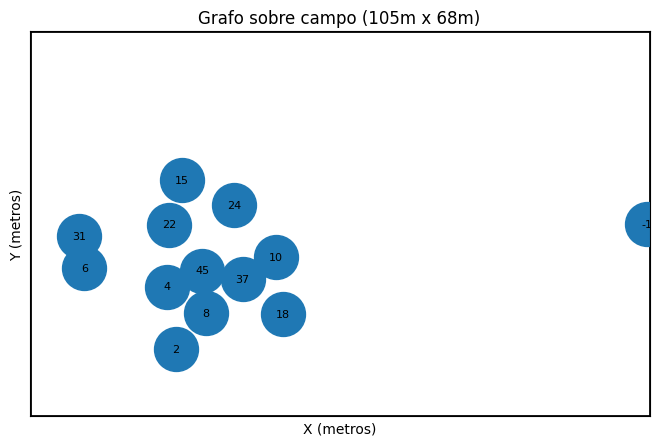

In [41]:
home_graph = graphs['16']
pos = nx.get_node_attributes(home_graph, 'pos')  # pega as posições dos nós
edge_widths = [d['weight'] for (_, _, d) in home_graph.edges(data=True)]  # lista de weights

fig, ax = plt.subplots(figsize=(8, 5))

# Desenha o retângulo do campo (105 x 68), centrado em (0,0)
campo = plt.Rectangle(
    (-52.5, -34),  # canto inferior esquerdo
    105,           # largura (x)
    68,            # altura (y)
    linewidth=2, 
    edgecolor='black', 
    facecolor='white',
    zorder=1       # zorder para ficar atrás das arestas
)
ax.add_patch(campo)

# Usa draw_networkx, que chama internamente as funções para desenhar nós, arestas e rótulos
nx.draw_networkx(
    home_graph, 
    pos=pos, 
    with_labels=True, 
    node_size=1000, 
    font_size=8, 
    width=edge_widths  # <-- aqui variamos a espessura de cada aresta
)

# Ajusta os limites do gráfico para caber exatamente o campo
ax.set_xlim([-52.5, 52.5])
ax.set_ylim([-34, 34])

# Remove eixos para ficar mais "limpo"
ax.set_xlabel("X (metros)")
ax.set_ylabel("Y (metros)")

plt.title("Grafo sobre campo (105m x 68m)")
plt.show()

In [42]:
pos

{-1: (52.0, 0.0),
 2: (-27.74564705882353, -22.11935294117647),
 8: (-22.569823529411764, -15.79270588235294),
 24: (-17.902588235294118, 3.3145882352941176),
 10: (-10.808470588235295, -5.856058823529412),
 22: (-28.873058823529412, -0.10517647058823533),
 6: (-43.21225, -7.716875),
 18: (-9.590411764705882, -15.980235294117646),
 37: (-16.402666666666665, -9.749),
 15: (-26.68811764705882, 7.820588235294117),
 4: (-29.275764705882352, -11.050882352941176),
 45: (-23.26229411764706, -8.231294117647058),
 31: (-44.12988235294117, -2.0992941176470588)}